# Structural Estimation of the Buffer-Stock Model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
from scipy.optimize import minimize
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt

# Buffer-Stock Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from BufferStockModel import BufferStockModelClass
model = BufferStockModelClass()

In [3]:
from consav.quadrature import normal_gauss_hermite 
x, w = normal_gauss_hermite(0.1,n=5)
print(x) # log normal shocks np.exp(x)
print(w)

[-2.85697001e-01 -1.35562618e-01  1.86468858e-17  1.35562618e-01
  2.85697001e-01]
[0.01125741 0.22207592 0.53333333 0.22207592 0.01125741]


Adding more points does not really change anything!
- high weight on center (50%), hardly any weight on tails
- if we increase n = 7 it is still centered around zero

## Solve the model

In [4]:
model.solve()
par = model.par
sol = model.sol

**Last period, $t=T-1$**

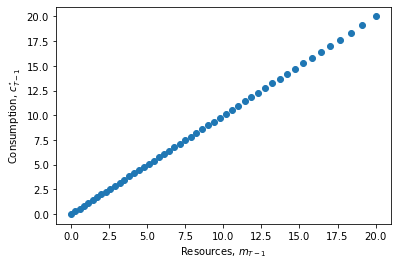

In [5]:
# last period consumption
t = par.T-1
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.c[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Consumption, $c_{T-1}^{\star}$');

- In the terminal period it is optimal to consume all ressources given there is no future.

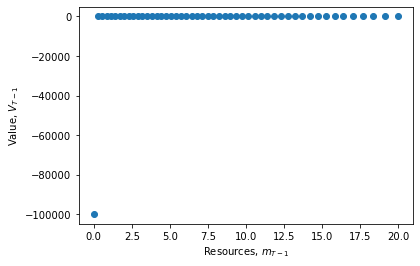

In [6]:
fig, ax = plt.subplots()
ax.scatter(par.m_grid,sol.V[t,:])
ax.set(xlabel='Resources, $m_{T-1}$',ylabel='Value, $V_{T-1}$');

It is because in the terminal period we have $v_T(m_T)=\frac{m_T^{(1-\rho)}}{1-\rho}$, and thus for $m_T=0$ we get minus infinity. Else we get something close to zero and for $m_T$ going to $\infty$ we converge to zero.

**Question 1:** Why does the value function look like this? <br> \[*hint:* try plotting all but the first point in the grid.\]

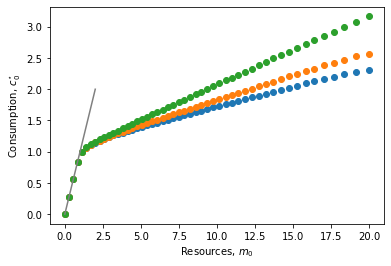

In [7]:
t = 0
fig, ax = plt.subplots()
for t in (0,5,10): #first, sixth and elleventh period of life
    ax.scatter(par.m_grid,sol.c[t,:])
ax.plot([0,2],[0,2],color='gray')
ax.set(xlabel='Resources, $m_{0}$',ylabel='Consumption, $c_{0}^{\star}$');

- grey is borrowing constraint (45 degree line where ressources equal to consumption) 
- around 1 consumption function detaches it self from credit constraint, meaning that for m less than 1 they don't save 

## Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by drawing transitory and permanent income shocks, `sim.xi` and `sim.psi`, from log normal distributions and initializing all state-variables in the first period and simulate forwards. 

We wish to simulate both normalized and un-normalized variables. We therefore have two state variables to initialize, wealth ($a_0$) and permanent income ($P_0$). We could also have initialized $m_0$ and $P_0$ but it feels more natural to initialize the level of wealth. 

We initilize all individuals with no wealth, `sim.a_init=np.zeros(par.simN)` and permanent income of 1, `sim.P_init=np.ones(par.simN)`. We then loop forward using the solution:
$$
\begin{align}
m_{i,t} &= (1+r)\cdot a_{i,t} / (G\cdot \psi_{i,t}) + \xi_{i,t}\\
c_{i,t} &= c_t^{\star}(m_{i,t}) \\
a_{i,t+1} &= m_{i,t} - c_{i,t} \\
P_{i,t+1} &= G\cdot P_{i,t} \cdot \psi_{i,t+1}
\end{align}
$$

In [8]:
model.simulate()
sim = model.sim

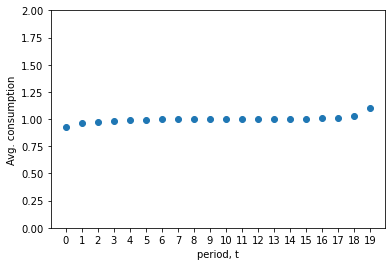

In [9]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

Almost perfect consumption smoothing.

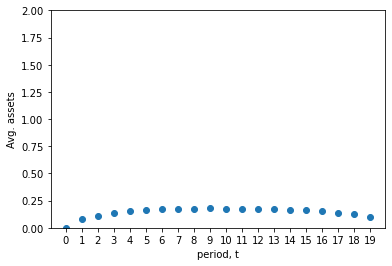

In [10]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

### Simulate Average Wealth with a larger discount factor of say $\beta=0.99$. Does the savings behavior change in an intuitive way?

In [11]:
model_beta_inc = BufferStockModelClass(par={'beta':0.99})
model_beta_inc.solve()
par = model_beta_inc.par
sol = model_beta_inc.sol

In [12]:
model_beta_inc.simulate()
sim_beta_inc = model_beta_inc.sim

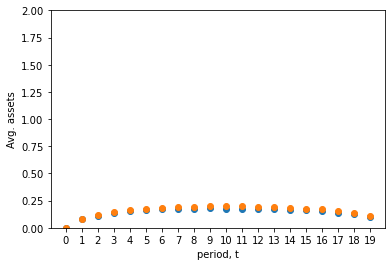

In [13]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.scatter(range(par.simT),np.mean(sim_beta_inc.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

If time preference is tilded more towards "tomorrow" then savings are increased which makes intuitive sense.

## Structural Estimation of $\theta=(\beta,\rho)$

In [14]:
def obj_func(theta,theta_names,mom_data,model,do_print=False):
    
    # printing
    if do_print: 
        print_str = ''
        for i,name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
            
    # calculate moments from simulation
    mom_sim = simulate_moments(theta,theta_names,model,do_print=False)
    
    # equal weighting
    obj = np.sum((mom_data - mom_sim)**2)
    
    # return objective and moments for plotting
    return obj

def simulate_moments(theta,theta_names,model,do_print=False):
        
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    model.solve()
    model.simulate()
    
    # return moments from simulated data
    return moment_func(model.sim)

def moment_func(input_data):
    return np.mean(input_data.A,axis=0) # age profile of wealth

In [15]:
# simulate synthetic data with a known set of parameters. 
beta_true = 0.98
rho_true = 2.0

data_model = BufferStockModelClass(par={'beta':beta_true,'rho':rho_true})

data_model.solve()
data_model.simulate()

mom_data = moment_func(data_model.sim) # moments in data

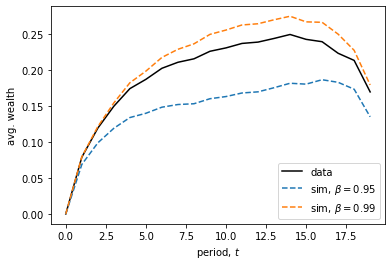

In [16]:
# Plot the different age-profiles for different values of, say, beta. the profiles are the 2.and 3. ourput from obj_func
mom_sim_95 = simulate_moments(np.array([0.95]),('beta',),model)
mom_sim_99 = simulate_moments(np.array([0.99]),('beta',),model)

fig, ax = plt.subplots()
ax.plot(range(par.simT),mom_data,label='data',color='black')
ax.plot(range(par.simT),mom_sim_95,linestyle='--',label=r'sim, $\beta=0.95$')
ax.plot(range(par.simT),mom_sim_99,linestyle='--',label=r'sim, $\beta=0.99$')
ax.set(xlabel='period, $t$',ylabel='avg. wealth')
ax.legend();

In [17]:
# evaluate objective function at truth. # it both has to solve and simulate
# Because the seed is the same, the objective function is exactly zero.
theta_names = ('beta','rho')
theta_true = np.array([beta_true,rho_true])
obj_true = obj_func(theta_true,theta_names,mom_data,model)
obj_true

0.0

- Changing beta

In [18]:
# evaluate objective function at truth. # it both has to solve and simulate
# Because the seed is the same, the objective function is exactly zero.
theta_names = ('beta','rho')
theta_true = np.array([0.95,rho_true])
obj_true = obj_func(theta_true,theta_names,mom_data,model)
obj_true

0.05436239967666663

In [19]:
# plot objective function 
beta_grid = np.linspace(0.95,1.0,7)
rho_grid = np.linspace(1.5,2.5,7)

obj = np.nan + np.ones((beta_grid.size,rho_grid.size))
for ibeta,beta in enumerate(beta_grid):
    for irho,rho in enumerate(rho_grid):
        theta = [beta,rho]
        obj[ibeta,irho] = obj_func(theta,theta_names,mom_data,model)

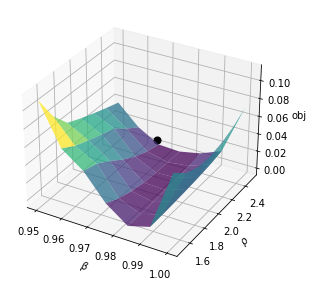

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(beta_grid, rho_grid,indexing='ij')
Z = obj

ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.scatter(beta_true,rho_true,obj_true,color='black',s=50)
ax.set(xlabel=r'$\beta$',ylabel=r'$\rho$',zlabel='obj');
plt.tight_layout()
plt.savefig('objective.pdf')  

In [21]:
# call numerical optimizer
objective = lambda theta: obj_func(theta,theta_names,mom_data,model,do_print=True)

theta_init = np.array([beta_true,rho_true]) * 0.98 # initialize to 2% lower than actual values

res = minimize(objective,theta_init,method='nelder-mead')
res

beta=0.960 rho=1.960 
beta=1.008 rho=1.960 
beta=0.960 rho=2.058 
beta=0.912 rho=2.058 
beta=0.936 rho=2.033 
beta=0.984 rho=1.985 
beta=1.008 rho=1.960 
beta=0.984 rho=2.083 
beta=1.008 rho=2.009 
beta=0.972 rho=2.046 
beta=0.996 rho=2.021 
beta=0.978 rho=2.040 
beta=0.978 rho=1.942 
beta=0.972 rho=1.997 
beta=0.981 rho=1.988 
beta=0.981 rho=2.086 
beta=0.979 rho=1.978 
beta=0.976 rho=2.030 
beta=0.980 rho=1.998 
beta=0.981 rho=1.936 
beta=0.982 rho=1.957 
beta=0.980 rho=1.972 
beta=0.981 rho=1.962 
beta=0.980 rho=1.970 
beta=0.981 rho=1.964 
beta=0.980 rho=1.968 
beta=0.980 rho=2.030 
beta=0.980 rho=2.007 
beta=0.980 rho=1.977 
beta=0.980 rho=1.993 
beta=0.980 rho=2.031 
beta=0.980 rho=2.016 
beta=0.980 rho=2.002 
beta=0.980 rho=2.006 
beta=0.980 rho=2.028 
beta=0.980 rho=2.002 
beta=0.980 rho=2.012 
beta=0.980 rho=2.007 
beta=0.980 rho=1.993 
beta=0.980 rho=2.010 
beta=0.980 rho=1.999 
beta=0.980 rho=2.007 
beta=0.980 rho=2.002 
beta=0.980 rho=2.006 
beta=0.980 rho=2.000 
beta=0.980

 final_simplex: (array([[0.98000019, 1.99998787],
       [0.98000107, 1.99990623],
       [0.9800004 , 1.99994866]]), array([9.59399951e-13, 1.09110817e-12, 2.70462047e-12]))
           fun: 9.59399950964544e-13
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 36
        status: 0
       success: True
             x: array([0.98000019, 1.99998787])

- terminates to value close to true value